In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Getting Started

In this notebook, we'll use a simple mask and correct for mode coupling.

In [2]:
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot

import nawrapper as nw
import nawrapper.maptools as maptools

Let's generate a random map to try doing analysis on.

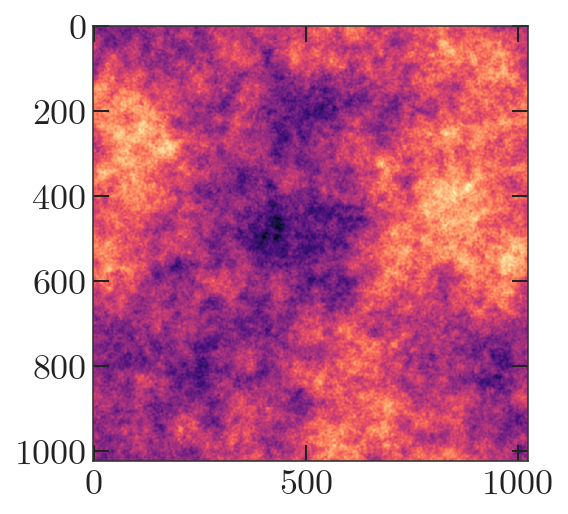

In [3]:
shape,wcs = enmap.geometry(shape=(1024,1024),
                           res=np.deg2rad(0.5/60.),pos=(0,0))
ells = np.arange(0,6000,1)
ps = np.zeros(len(ells))
ps[2:] = 1/ells[2:]**2.5 # don't want monopole/dipole
imap = enmap.rand_map(shape,wcs,ps[np.newaxis,np.newaxis])
plt.imshow(imap)

Next, let's generate a point source map. We'll add these sources to the map, and apodize to generate a mask.

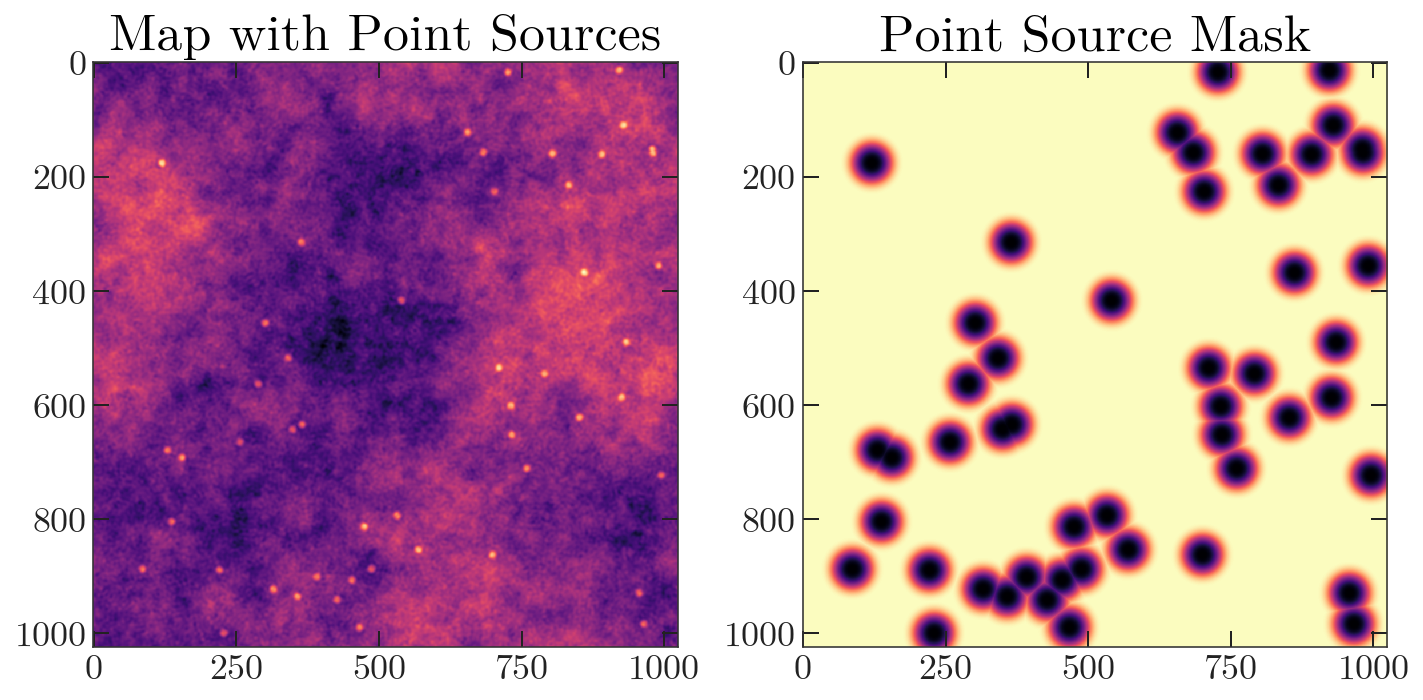

In [4]:
mask = enmap.ones(imap.shape, imap.wcs)

N_point_sources = 50
for i in range(N_point_sources):
    mask[ 
        np.random.randint(low=0, high=mask.shape[0]), 
        np.random.randint(low=0, high=mask.shape[1]) ] = 0
point_source_map = 1 - maptools.apod_C2(mask, 0.1)
imap += point_source_map
mask = maptools.apod_C2(mask, 0.5)

fig, axes = plt.subplots(1, 2, figsize=(10,20))
axes[0].imshow(imap)
axes[1].imshow(mask)
axes[0].set_title('Map with Point Sources')
axes[1].set_title('Point Source Mask')
plt.tight_layout()

Now let's do two noise realizations.

Text(0.5, 0, 'Multipole $\\ell$')

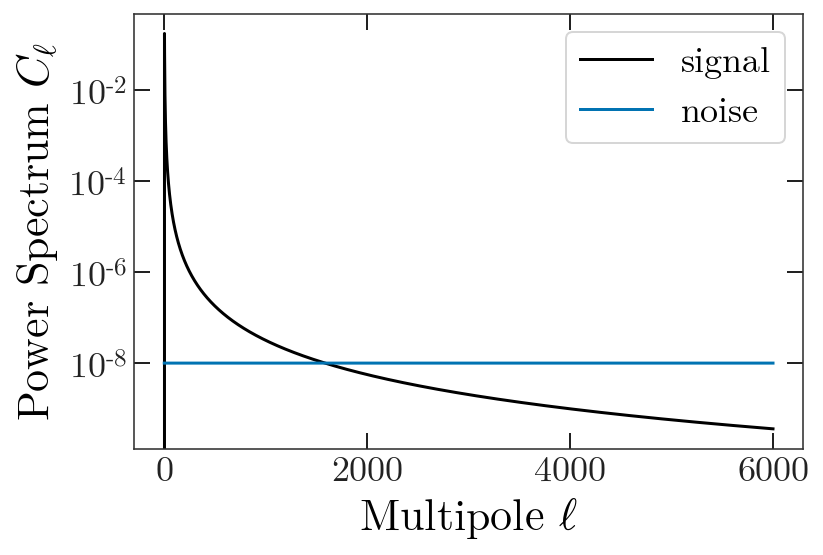

In [5]:
ells = np.arange(0,len(ps),1)
nl = np.ones(len(ells)) * 1e-8

plt.figure(figsize=(6,4))
plt.plot(ps, "-", label="signal")
plt.plot(nl, "-", label="noise")
plt.yscale('log')
plt.legend()
plt.ylabel(r'Power Spectrum $C_{\ell}$')
plt.xlabel(r'Multipole $\ell$')

In [6]:
noise_map_1 = enmap.rand_map(shape, wcs,
                             nl[np.newaxis, np.newaxis])
noise_map_2 = enmap.rand_map(shape, wcs,
                             nl[np.newaxis, np.newaxis])

For this example we won't include a beam. Let's set up the namap objects.

# The Power Spectrum Part

In [7]:
namap_1 = nw.namap_car(maps=(imap + noise_map_1, None, None), masks=mask)
namap_2 = nw.namap_car(maps=(imap + noise_map_2, None, None), masks=mask)

Assuming the same mask for both I and QU.
Creating a car namap. temperature: True, polarization: False
temperature beam not specified, setting temperature beam to 1.
Applying a k-space filter (kx=0, ky=0, apo=40), unpixwin: True
Computing spherical harmonics.

Assuming the same mask for both I and QU.
Creating a car namap. temperature: True, polarization: False
temperature beam not specified, setting temperature beam to 1.
Applying a k-space filter (kx=0, ky=0, apo=40), unpixwin: True
Computing spherical harmonics.



Now let's compute the mode coupling matrix. First we need to set up a binning object. The easiest way to do this is `create_binning` from nawrapper, which takes a function for the weights and either a list of bin widths for `widths=` or an integer (in which case all bins will have the same width).

You can load this from file (see `nw.read_bins`))

In [8]:
# 40 bins of 50 and 50 bins of width 100
# lmax cuts off the end bins, so nothing over 6000 is included
bins = nw.create_binning(lmax=6000, lmin=200, 
                         widths=[50]*40 + [100]*50, 
                         weight_function=(lambda ell : ell**2))

We associate a mode-coupling object with a directory. Here, we specify a relative path. The mode-coupling object will write the matrices to disk when it is done computing. Future runs will look at the specified path for precomputed mode-coupling matrices, and read them in if they exist. To recompute matrices, specify the argument `overwrite=True`.

In [13]:
mc = nw.mode_coupling(namap_1, namap_2, bins, mcm_dir='./quickstart_mcm/')

Computing new mode-coupling matrices.
Saving mode-coupling matrices to ./quickstart_mcm/


Finally, we can compute some spectra!

In [14]:
Cb = nw.compute_spectra(namap_1, namap_2, mc=mc)
print(Cb.keys())

dict_keys(['TT', 'ell'])


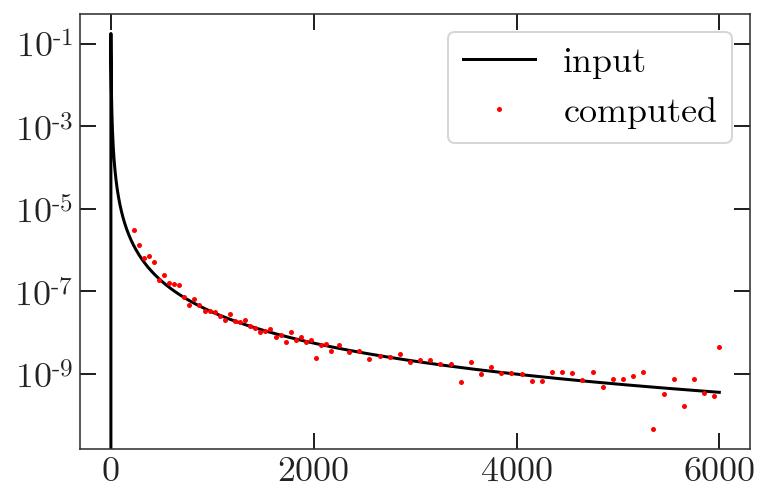

In [15]:
plt.plot(ps, 'k-', label='input')
plt.plot(Cb['ell'], Cb['TT'], 'r.', label='computed')
plt.legend()
plt.yscale('log')